# Development Manuscript Analysis: univariate
This notebook addresses all three endpoint using univariate techniques tor all 20 proteins on the CAP.

In [1]:
# Package imports...
# Basic:
import os
import sys
import psutil
# Data handling:
import io
import json
import pandas as pd
# Computations:
from datetime import datetime
from time import sleep
import numpy as np
import ray
from scipy.stats import spearmanr, pearsonr, linregress, ttest_ind
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve
# Visualization:
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# Object persistance:
import joblib
# Constants...
fig_font   = { "weight": "bold", "size": 12 }
title_font = { "weight": "bold", "size": 16 }
small_font = { "weight": "bold", "size": 8 }
matplotlib.rc( "font", **fig_font )

## Read in the F4, F5, and ACP data.
We're not reading from Domo because this paper is about the relative quantitation data taken in mid 2019 and analyzed in late 2019 through 2020. As such, we are reading archival versions of the protein concentration values that were uplaoded to Athena. Those are currently stored on [google drive](https://drive.google.com/drive/folders/1dYgunVtA0w50oRdW2MS0PDZI18NW5Ba7?usp=sharing).

In [2]:
# Specify the file names for the data tables.
excel_file_names = { "f4": "F4_Intensity_LOD_QC_ExtraOncologyIII-Olink+RBM_Shifts_OCTAVE_CONFIDENTIAL+PROPRIETARY_Log2RBM_3TF.xlsx", \
                     "f5": "F5_EPIC_Intensity_LOD_QC_Olink_OCTAVE_CONFIDENTIAL+PROPRIETARY_3TF.xlsx", \
                    "acp": "ACP_LOD_QC_Olink_OCTAVE_CONFIDENTIAL+PROPRIETARY_Log2RBM_3TF.xlsx" }
# Read in the protein tables.
print( "Reading protien data..." )
read_start = datetime.now()
protein_tables = { study: pd.read_excel( "./protein_data/{:}".format( file_name ), sheet_name = "prot", index_col = "sample.barcode" ) \
                   for study, file_name in excel_file_names.items() }
print( "\t...Finished in", datetime.now() - read_start )
# Same for the clinical tables.
print( "Reading clinical data..." )
read_start = datetime.now()
clinical_tables = { study: pd.read_excel( "./protein_data/{:}".format( file_name ), sheet_name = "clin_analysis", index_col = "sample.barcode" ) \
                    for study, file_name in excel_file_names.items() }
print( "\t...Finished in", datetime.now() - read_start )

Reading protien data...
	...Finished in 0:00:03.970397
Reading clinical data...
	...Finished in 0:00:00.202177


## Extract the LIMS IDs/sample barcodes that correspond to real samples
The logic for this is _a little_ different for different studies, so we're going to handle them separately.

In [3]:
valid_lims_ids = { "f4": sorted( clinical_tables[ "f4" ][ clinical_tables[ "f4" ][ "Patient_Group" ].str.contains( "AIM3" ) ].index ), 
                   "f5": sorted( clinical_tables[ "f5" ][ clinical_tables[ "f5" ][ "Collection_Group" ] == "F5_EPIC" ].index ), \
                  "acp": sorted( clinical_tables[ "acp" ][ ~clinical_tables[ "acp" ][ "Patient_Group" ].str.contains( "_PC" ) ].index ) }

## Bridge normalize the protein data from F5 to match the F4 Redo samples

In [4]:
# Define the list of biomarkers on the CAP...
biomarker_columns = [ "APLP1-Olink METABOLISM",    "CCL20-Olink INFLAMMATION",    "CD6-Olink INFLAMMATION",            "CDCP1-Olink INFLAMMATION",          "COL4A1-Olink CELL REGULATION", \
                      "CNTN2-Olink ORGAN DAMAGE",  "CXCL13-Olink ONCOLOGY II",    "CXCL9-Olink INFLAMMATION",          "FLRT2-Olink NEUROLOGY",             "GH-Olink CARDIOVASCULAR II", \
                      "IL-12B-Olink INFLAMMATION", "MOG-Olink CELL REGULATION",   "NEFL-Olink NEURO EXPLORATORY",      "OPG-Olink INFLAMMATION",            "OPN-Olink CARDIOVASCULAR III", \
                      "PRTG-Olink NEUROLOGY",      "SERPINA9-Olink ORGAN DAMAGE", "TNFRSF10A-Olink CARDIOVASCULAR II", "TNFSF13B-Olink CARDIOVASCULAR III", "VCAN-Olink METABOLISM" ]
# Identify the protein column names in the combined table.
protein_columns = [ bmkr.split( "-Olink" )[ 0 ].lower() for bmkr in biomarker_columns ]
# Isolate thee sample IDs for the redo samples in F5.
bridge_sample_ids = clinical_tables[ "f5" ][ clinical_tables[ "f5" ][ "Collection_Group" ] == "AIM3_F4_redo" ].index
# Perform a linear regression to find the mapping of NPX values from F5 into the scale for F4 for each protein.
bridge_normalization_regr = { prot: linregress( protein_tables[ "f4" ].loc[ bridge_sample_ids ][ protein_tables[ "f4" ].loc[ bridge_sample_ids ][ bmkr ].notna() & \
                                                                                                 protein_tables[ "f5" ].loc[ bridge_sample_ids ][ bmkr ].notna() ][ bmkr ].values, \
                                                protein_tables[ "f5" ].loc[ bridge_sample_ids ][ protein_tables[ "f4" ].loc[ bridge_sample_ids ][ bmkr ].notna() & \
                                                                                                 protein_tables[ "f5" ].loc[ bridge_sample_ids ][ bmkr ].notna() ][ bmkr ].values ) \
                              for prot, bmkr in zip( protein_columns, biomarker_columns ) }
# Now create the adjusted NPX values for F5.
bridge_normalized_npx = { prot: ( protein_tables[ "f5" ].loc[ valid_lims_ids[ "f5" ] ][ bmkr ] * bridge_normalization_regr[ prot ].slope ) + bridge_normalization_regr[ prot ].intercept \
                          for prot, bmkr in zip( protein_columns, biomarker_columns ) }
# Finally, update the salient values in the F5 study.
for prot, bmkr in zip( protein_columns, biomarker_columns ):
    for lims_id in valid_lims_ids[ "f5" ]:
        protein_tables[ "f5" ].at[ lims_id, bmkr ] = bridge_normalized_npx[ prot ].loc[ lims_id ]

## Select the columns we need from each study and join the protein and clinical tables.

In [5]:
 # Now, add the sample ID and protein columns to the combined table, and use the sample ID as the index value.
combined_tables = { study: pd.DataFrame( { bmkr.split( "-Olink" )[ 0 ].lower(): protein_tables[ study ].loc[ valid_lims_ids[ study ] ][ bmkr ].values.astype( np.float64 ) \
                                           for bmkr in biomarker_columns }, \
                                         index = valid_lims_ids[ study ] ) \
                    for study, lims_ids in valid_lims_ids.items() } 
# Set the clinical columns we are keeping for each study. Recall that:
#   F4 contributes to both the Gd lesion and ARR endpoints
#   F5 contributes only to the Gd lesion endpoint
#   ACP contributes only to the cliniical relapse endpoint
clinical_columns = { "f4": [ "Brain_Lesions", "ARR", "Age", "Sex", "DiseaseDuration", "Delta_BloodMinusDiagnosis" ], \
                     "f5": [ "Brain_Lesions", "Age", "Sex", "DiseaseDuration", "Delta_BloodMinusDiagnosis" ], \
                   "aim1": [ "ARR", "Age", "Sex", "DiseaseDuration" ], \
                    "acp": [ "Label", "Age", "Sex", "DiseaseDuration" ] }
# Now iterate through the studies and the clinical tables associated with each, and add them into the combined table.
# Iterate over the studies...
for study, lims_ids in valid_lims_ids.items():
    # ...and over the clinical columns...
    for clin_col in clinical_columns[ study ]:
        combined_tables[ study ][ clin_col.lower().replace( "sedu", "se_du" ).replace( "odmi", "od_mi" ).replace( "usdi", "us_di") ] = clinical_tables[ study ].loc[ lims_ids ][ clin_col ].values.astype( np.float64 )

## Gd lesions
We're going to start with the univariate figures for Gd lesions. First, we have to concatenate the F4 and F5 data, keeping only the protien concentrations, brain lesion count, and demographic data.

In [6]:
# Pick the clinical columns we need for Gd lesion analysis.
gd_clinical_columns = [ "brain_lesions", "age", "sex", "disease_duration", "delta_blood_minus_diagnosis" ]
gd_lesion_data = pd.concat( [ combined_tables[ "f4" ][ protein_columns + gd_clinical_columns ], \
                              combined_tables[ "f5" ][ protein_columns + gd_clinical_columns ] ], \
                            axis = 0, ignore_index = False )
# Drop all the samples where the blood draw was more than 30 days frmo the MRI.
gd_lesion_data = gd_lesion_data[ gd_lesion_data[ "delta_blood_minus_diagnosis" ].abs() < 30. ]

### Box and whisker plot

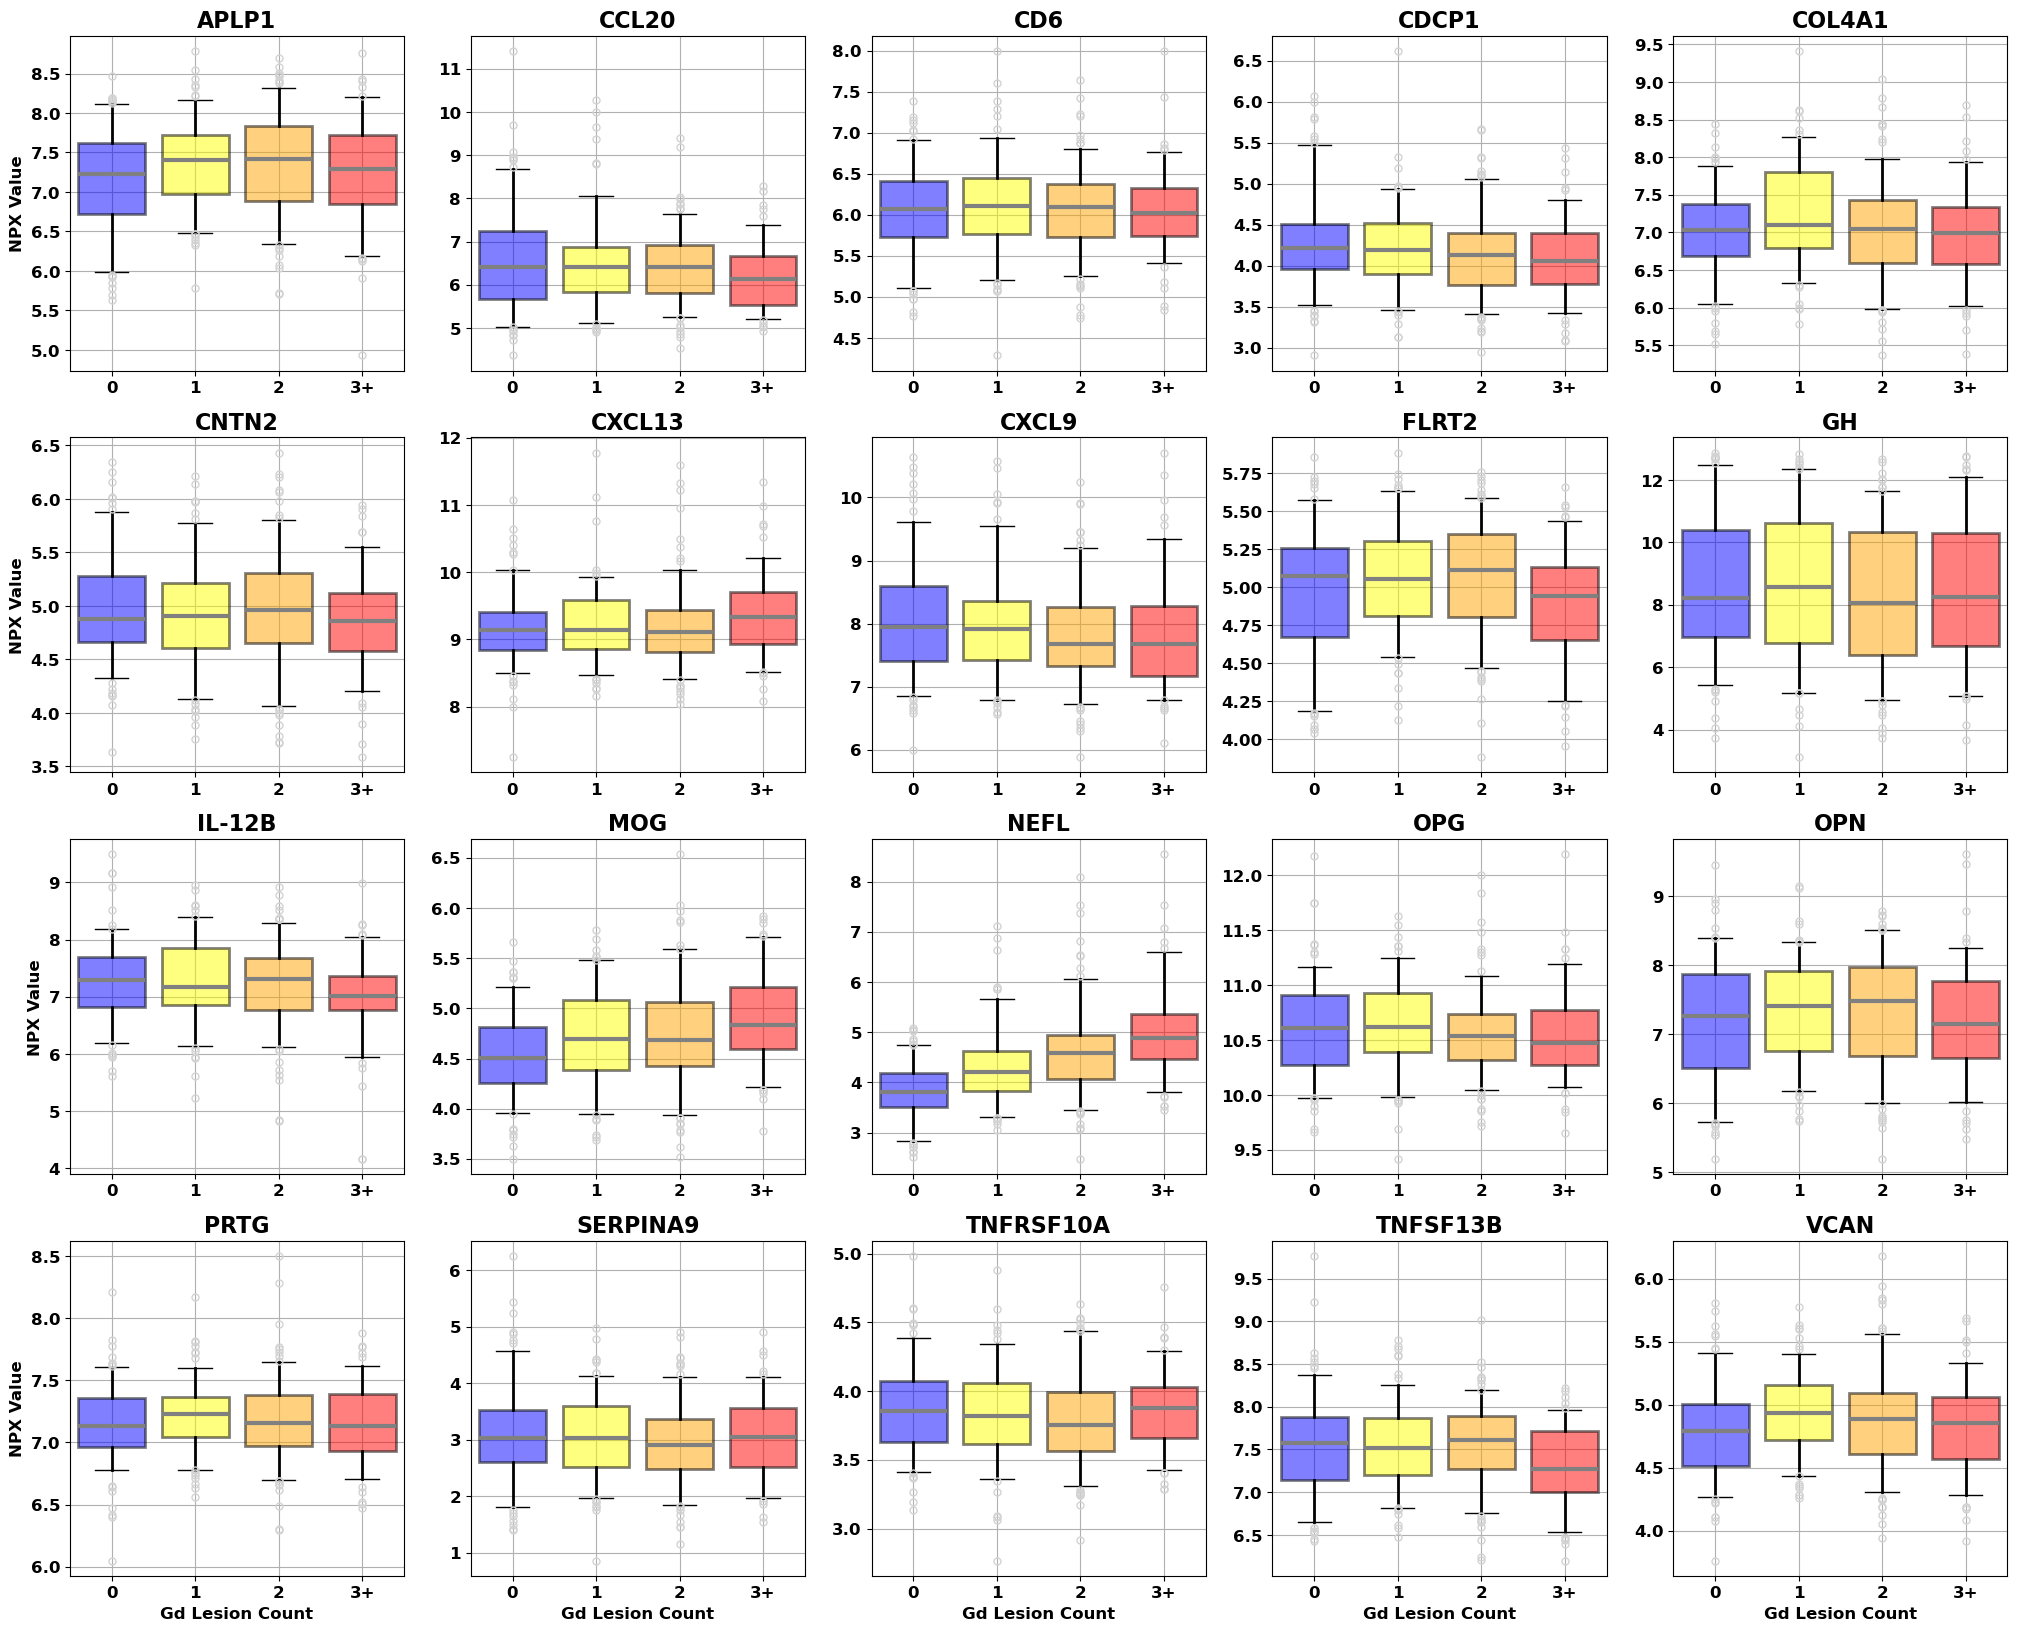

In [7]:
# Box and whisker configurations.
box_median_cfg = { "color": "gray", "linewidth": 3. }
flier_cfg = { "markeredgecolor": "lightgray", "markersize": 5. }
box_cfg = { "edgecolor": "black", "linewidth": 2., "facecolor": "wheat", "alpha": 0.5 }
whsk_cfg = { "color": "black", "linewidth": 2. }
box_colors = [ "blue", "yellow", "orange", "red" ]
# Create the figure.
fig, sub_plot = plt.subplots( 4, 5, figsize = ( 25., 20. ), facecolor = "white", edgecolor = "white" )
# Iterate over the subplots and protein features.
box_plots = [ sp.boxplot( [ gd_lesion_data[ ( gd_lesion_data[ "brain_lesions" ] == 0. ) & gd_lesion_data[ bmkr ].notna() ][ bmkr ].values, \
                            gd_lesion_data[ ( gd_lesion_data[ "brain_lesions" ] == 1. ) & gd_lesion_data[ bmkr ].notna() ][ bmkr ].values, \
                            gd_lesion_data[ ( gd_lesion_data[ "brain_lesions" ] == 2. ) & gd_lesion_data[ bmkr ].notna() ][ bmkr ].values, \
                            gd_lesion_data[ ( gd_lesion_data[ "brain_lesions" ] >= 3. ) & gd_lesion_data[ bmkr ].notna() ][ bmkr ].values ], \
                          positions = np.arange( 4 ), sym = "o", patch_artist = True, widths = 0.8, whis = [ 5., 95. ], notch = False, \
                          boxprops = box_cfg, medianprops = box_median_cfg, whiskerprops = whsk_cfg, flierprops = flier_cfg ) \
              for sp, bmkr in zip( sub_plot.ravel(), protein_columns ) ]
# Formatting.
for sp, bmkr, box_plot in zip( sub_plot.ravel(), protein_columns, box_plots ):
    sp.set_title( bmkr.upper(), fontdict = title_font )
    sp.set_xticklabels( [ "0", "1", "2", "3+" ] )
    if sp in sub_plot[ 3, : ]:
        sp.set_xlabel( "Gd Lesion Count", fontdict = fig_font )
    if sp in sub_plot[ :, 0 ]:
        sp.set_ylabel( "NPX Value", fontdict = fig_font )
    for patch, color in zip( box_plot[ "boxes" ], box_colors ):
        patch.set_facecolor( color )
    sp.grid( True )
plt.savefig( "./latex/figures/univar_boxplots_gd.png", dpi = 300, bbox_inches = "tight" )
plt.savefig( "./latex/figures/univar_boxplots_gd.pdf", dpi = 300, bbox_inches = "tight" )

### Correlation/Separation Analysis

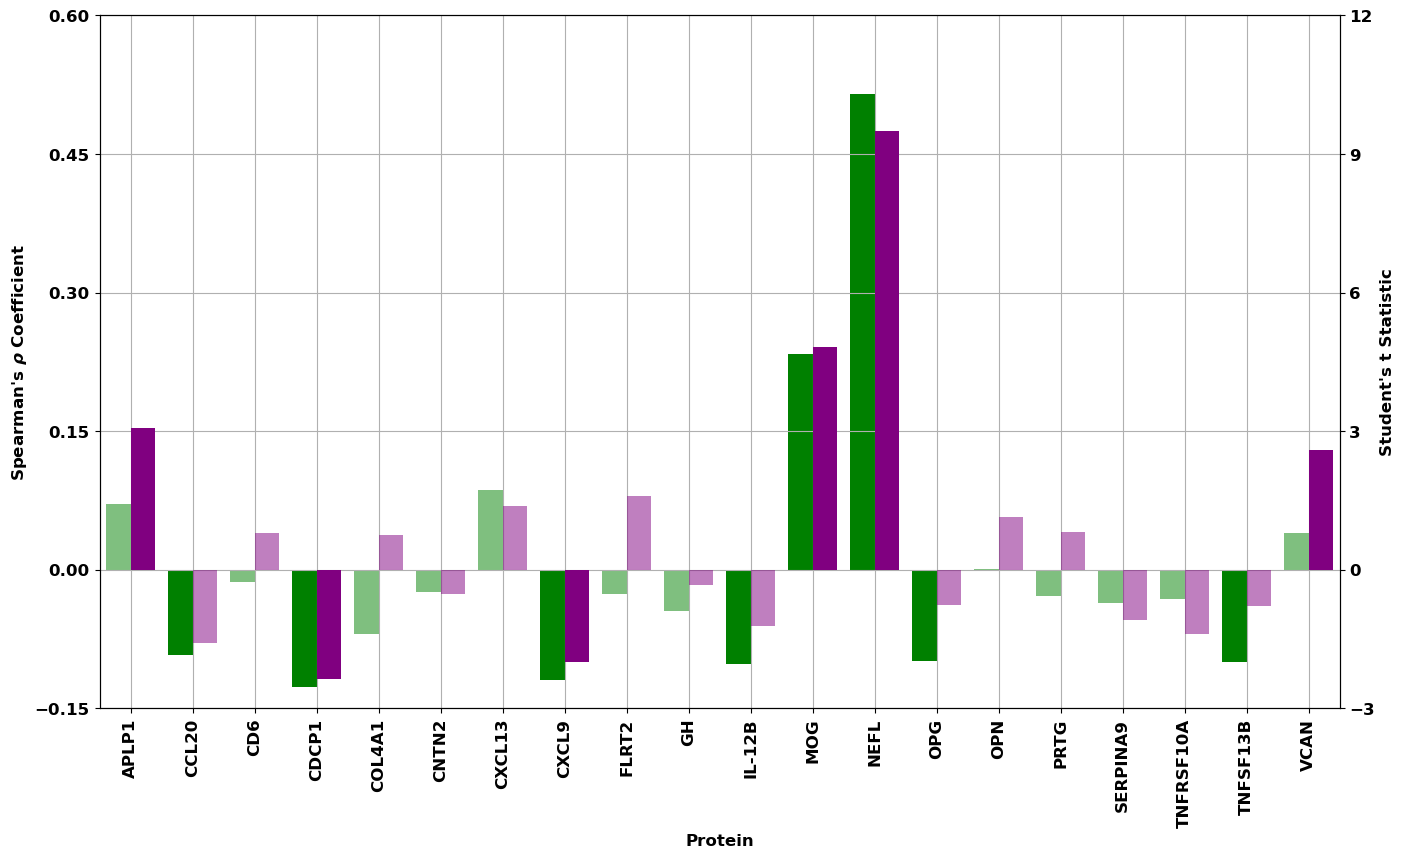

In [8]:
# Set the upper clip limit for lesion count regression.
gd_les_ul = np.inf
# Pearson correlation for each protein
gd_correlations = { prot: pearsonr( gd_lesion_data[ "brain_lesions" ][ gd_lesion_data[ "brain_lesions" ].notna() & gd_lesion_data[ prot ].notna() ].clip( lower = 0., upper = gd_les_ul ).values, \
                                     gd_lesion_data[      prot       ][ gd_lesion_data[ "brain_lesions" ].notna() & gd_lesion_data[ prot ].notna() ].values ) \
                    for prot in protein_columns }
# Spearman correlation for each protein
gd_corr_spr = { prot: spearmanr( gd_lesion_data[ "brain_lesions" ][ gd_lesion_data[ "brain_lesions" ].notna() & gd_lesion_data[ prot ].notna() ].clip( lower = 0., upper = gd_les_ul ).values, \
                                 gd_lesion_data[      prot       ][ gd_lesion_data[ "brain_lesions" ].notna() & gd_lesion_data[ prot ].notna() ].values ) \
                for prot in protein_columns }
# Pick the correlation to show.
corr_plot = gd_corr_spr
# Univariate Student's t-test for GDA.
gd_t_tests = { prot: ttest_ind( gd_lesion_data[ gd_lesion_data[ "brain_lesions" ].notna() & gd_lesion_data[ prot ].notna() & ( gd_lesion_data[ "brain_lesions" ] >= 1. ) ][ prot ].values, \
                                gd_lesion_data[ gd_lesion_data[ "brain_lesions" ].notna() & gd_lesion_data[ prot ].notna() & ( gd_lesion_data[ "brain_lesions" ] == 0. ) ][ prot ].values ) \
               for prot in protein_columns }
# Now plot both of these results together. Define some plotting constants.
bar_width, n_bars = 0.8, 2
bar_offsets = np.arange( 0., bar_width, bar_width / n_bars ) + ( bar_width / n_bars / 2. ) - ( bar_width / 2. )
# Create the figure.
fig, sub_plot = plt.subplots( 1, 1, figsize = ( 16., 9. ), facecolor = "white", edgecolor = "white" )
rhs_plot = sub_plot.twinx()
# Plot the test statistics for the correlation and sepatation analysis.
cor_bars = sub_plot.bar( np.arange( len( protein_columns ) ) + bar_offsets[ 0 ], [ corr_plot[ prot ][ 0 ] for prot in protein_columns ], \
                         width = bar_width / n_bars, align = "center", color = "green" )
sep_bars = rhs_plot.bar( np.arange( len( protein_columns ) ) + bar_offsets[ 1 ], [ gd_t_tests[ prot ].statistic for prot in protein_columns ], \
                         width = bar_width / n_bars, align = "center", color = "purple" )
# Turn down the alpha on bars corresponding to tests that were not significant.
signif_thr, low_alpha = 0.05, 0.5
for cor_bar, prot in zip( cor_bars, protein_columns ):
    if corr_plot[ prot ][ 1 ] > signif_thr:
        cor_bar.set_alpha( low_alpha )
for sep_bar, prot in zip( sep_bars, protein_columns ):
    if gd_t_tests[ prot ].pvalue > signif_thr:
        sep_bar.set_alpha( low_alpha )
# Formatting.
sub_plot.set_xlim( [-0.5, len( protein_columns ) - 0.5 ] )
sub_plot.set_xticks( np.arange( len( protein_columns ) ) )
sub_plot.set_xticklabels( [ prot.upper() for prot in protein_columns ], rotation = 90., fontdict = fig_font )
sub_plot.set_xlabel( "Protein", fontdict = fig_font )
# sub_plot.set_ylim( [ -0.25, 0.5 ] )
sub_plot.set_ylim( [ -0.15, 0.6 ] )
sub_plot.set_yticks( np.linspace( *sub_plot.get_ylim(), 6 ) )
# sub_plot.set_ylabel( "Pearson's R Coefficient", fontdict = fig_font )
sub_plot.set_ylabel( "Spearman's $\\rho$ Coefficient", fontdict = fig_font )
# rhs_plot.set_ylim( [ -5., 10. ] )
rhs_plot.set_ylim( [ -3., 12. ] )
rhs_plot.set_yticks( np.linspace( *rhs_plot.get_ylim(), 6 ) )
rhs_plot.set_ylabel( "Student's t Statistic", fontdict = fig_font )
sub_plot.grid( True )
plt.savefig( "./latex/figures/univar_corr_sep_gd.png", dpi = 300, bbox_inches = "tight" )
plt.savefig( "./latex/figures/univar_corr_sep_gd.pdf", dpi = 300, bbox_inches = "tight" )

### Tabulate the p-values from both of these analyses.

In [9]:
pd.DataFrame( { "Pearson p-Val.": [ "{:1.3e}".format( gd_correlations[ prot ][ 1 ] ) for prot in protein_columns ], \
               "Spearman p-Val.": [ "{:1.3e}".format(     gd_corr_spr[ prot ][ 1 ] ) for prot in protein_columns ], \
         "Classification p-Val.": [ "{:1.3e}".format( gd_t_tests[ prot ].pvalue ) for prot in protein_columns ] }, \
              index = [ prot.upper() for prot in protein_columns ] )

,Pearson p-Val.,Spearman p-Val.,Classification p-Val.
APLP1,9.417e-01,1.141e-01,2.302e-03
CCL20,2.387e-02,4.188e-02,1.118e-01
CD6,2.571e-01,7.800e-01,4.208e-01
CDCP1,1.548e-02,5.010e-03,1.805e-02
COL4A1,1.293e-01,1.219e-01,4.544e-01
CNTN2,3.484e-01,5.926e-01,6.019e-01
CXCL13,2.462e-02,5.617e-02,1.670e-01
CXCL9,1.946e-02,8.350e-03,4.717e-02
FLRT2,2.101e-01,5.646e-01,1.123e-01
GH,4.691e-01,3.324e-01,7.440e-01


In [10]:
pd.DataFrame( { "Pearson p-Val.": [ "{:1.3e}".format( gd_correlations[ prot ][ 1 ] ) if gd_correlations[ prot ][ 1 ] < signif_thr else "" for prot in protein_columns ], \
               "Spearman p-Val.": [ "{:1.3e}".format(     gd_corr_spr[ prot ][ 1 ] ) if     gd_corr_spr[ prot ][ 1 ] < signif_thr else "" for prot in protein_columns ], \
         "Classification p-Val.": [ "{:1.3e}".format( gd_t_tests[ prot ].pvalue ) if gd_t_tests[ prot ].pvalue < signif_thr else "" for prot in protein_columns ] }, \
              index = [ prot.upper() for prot in protein_columns ] )

,Pearson p-Val.,Spearman p-Val.,Classification p-Val.
APLP1,,,2.302e-03
CCL20,2.387e-02,4.188e-02,
CD6,,,
CDCP1,1.548e-02,5.010e-03,1.805e-02
COL4A1,,,
CNTN2,,,
CXCL13,2.462e-02,,
CXCL9,1.946e-02,8.350e-03,4.717e-02
FLRT2,,,
GH,,,


Now, tabluate the proteins ranked by their p-value.

In [11]:
pd.DataFrame( { "Regression (Pearson)": [ "{:} ({:1.3e})".format( protein_columns[ ind ].upper(), gd_correlations[ protein_columns[ ind ] ][ 1 ] ) \
                                          for ind in np.array( [ gd_correlations[ prot ][ 1 ] for prot in protein_columns ] ).argsort() ], \
               "Regression (Spearman)": [ "{:} ({:1.3e})".format( protein_columns[ ind ].upper(), gd_corr_spr[ protein_columns[ ind ] ][ 1 ] ) \
                                          for ind in np.array( [ gd_corr_spr[ prot ][ 1 ] for prot in protein_columns ] ).argsort() ], \
                      "Classification": [ "{:} ({:1.3e})".format( protein_columns[ ind ].upper(), gd_t_tests[ protein_columns[ ind ] ].pvalue ) \
                                          for ind in np.array( [ gd_t_tests[ prot ].pvalue for prot in protein_columns ] ).argsort() ] }, \
              index = np.arange( 1, len( protein_columns ) + 1 ) )

,Regression (Pearson),Regression (Spearman),Classification
1,NEFL (3.831e-18),NEFL (3.306e-34),NEFL (1.030e-19)
2,MOG (7.710e-06),MOG (1.602e-07),MOG (1.901e-06)
3,TNFSF13B (2.276e-04),CDCP1 (5.010e-03),APLP1 (2.302e-03)
4,IL-12B (2.714e-04),CXCL9 (8.350e-03),VCAN (9.926e-03)
5,CDCP1 (1.548e-02),IL-12B (2.411e-02),CDCP1 (1.805e-02)
6,CXCL9 (1.946e-02),TNFSF13B (2.722e-02),CXCL9 (4.717e-02)
7,CCL20 (2.387e-02),OPG (2.841e-02),CCL20 (1.118e-01)
8,CXCL13 (2.462e-02),CCL20 (4.188e-02),FLRT2 (1.123e-01)
9,PRTG (3.940e-02),CXCL13 (5.617e-02),TNFRSF10A (1.637e-01)
10,OPG (6.769e-02),APLP1 (1.141e-01),CXCL13 (1.670e-01)


## Clinical relapse status (ACP)
This is really ONLY a binary question. Let's start with a box plot comparing the quiescent (label = 0) and exacerbation (label = 1) samples.

In [12]:
combined_tables[ "acp" ]

,aplp1,ccl20,cd6,cdcp1,col4a1,cntn2,cxcl13,cxcl9,flrt2,gh,...,opn,prtg,serpina9,tnfrsf10a,tnfsf13b,vcan,label,age,sex,disease_duration
AC000031 0023,4.01997,5.15885,2.57388,2.98138,3.46770,2.30934,9.30179,6.88680,1.76361,6.65635,...,5.42663,5.51322,1.92270,2.50455,6.06164,1.01372,1.0,36.0,0.0,1.0
AC000037 0017,3.78438,5.09048,2.91111,2.08334,3.90381,1.79759,8.53926,7.46313,1.51807,8.59590,...,7.00414,5.73630,0.92736,2.12522,5.61180,1.57206,0.0,33.0,1.0,6.0
AC000053 0012,4.24472,4.71416,2.08355,1.56717,3.91218,2.21554,11.55571,6.54980,1.49481,7.79653,...,6.20030,5.72913,1.47181,1.98388,5.48888,1.70678,1.0,31.0,0.0,8.0
AC000060 0018,4.96489,3.10582,2.69185,2.01787,3.24580,2.63688,7.98698,8.14639,1.32033,6.13928,...,4.89420,5.49955,2.64009,1.93309,5.09481,1.26980,0.0,49.0,0.0,3.0
AC000137 0016,3.52153,NaN,NaN,NaN,4.23692,2.69759,7.50180,NaN,1.15981,9.02440,...,4.86589,5.46253,1.09184,2.17014,5.13935,1.71536,0.0,36.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC002980 0019,5.39415,3.61435,2.96417,1.51821,4.78745,3.36892,7.78104,6.47657,1.90008,9.62973,...,6.53409,6.11129,1.56991,2.66646,4.87228,1.83719,1.0,49.0,0.0,10.0
AC002994 0014,4.57458,4.55844,2.81836,1.83274,3.77299,2.26769,7.15762,7.66095,1.86871,6.27377,...,5.21217,6.06144,1.13430,2.26027,6.86669,1.76892,1.0,31.0,0.0,1.0
AC003087 0011,4.36676,4.00992,3.14586,1.62204,4.73219,2.39090,7.61329,6.69634,1.76763,4.89103,...,6.21824,5.63455,1.53132,2.33447,5.69952,1.46477,1.0,29.0,0.0,0.0
AC003351 0012,4.32735,NaN,NaN,NaN,4.17545,2.74986,7.40046,NaN,1.11198,10.49909,...,5.01208,5.94230,1.70917,1.93647,4.95632,1.09441,1.0,36.0,0.0,0.0


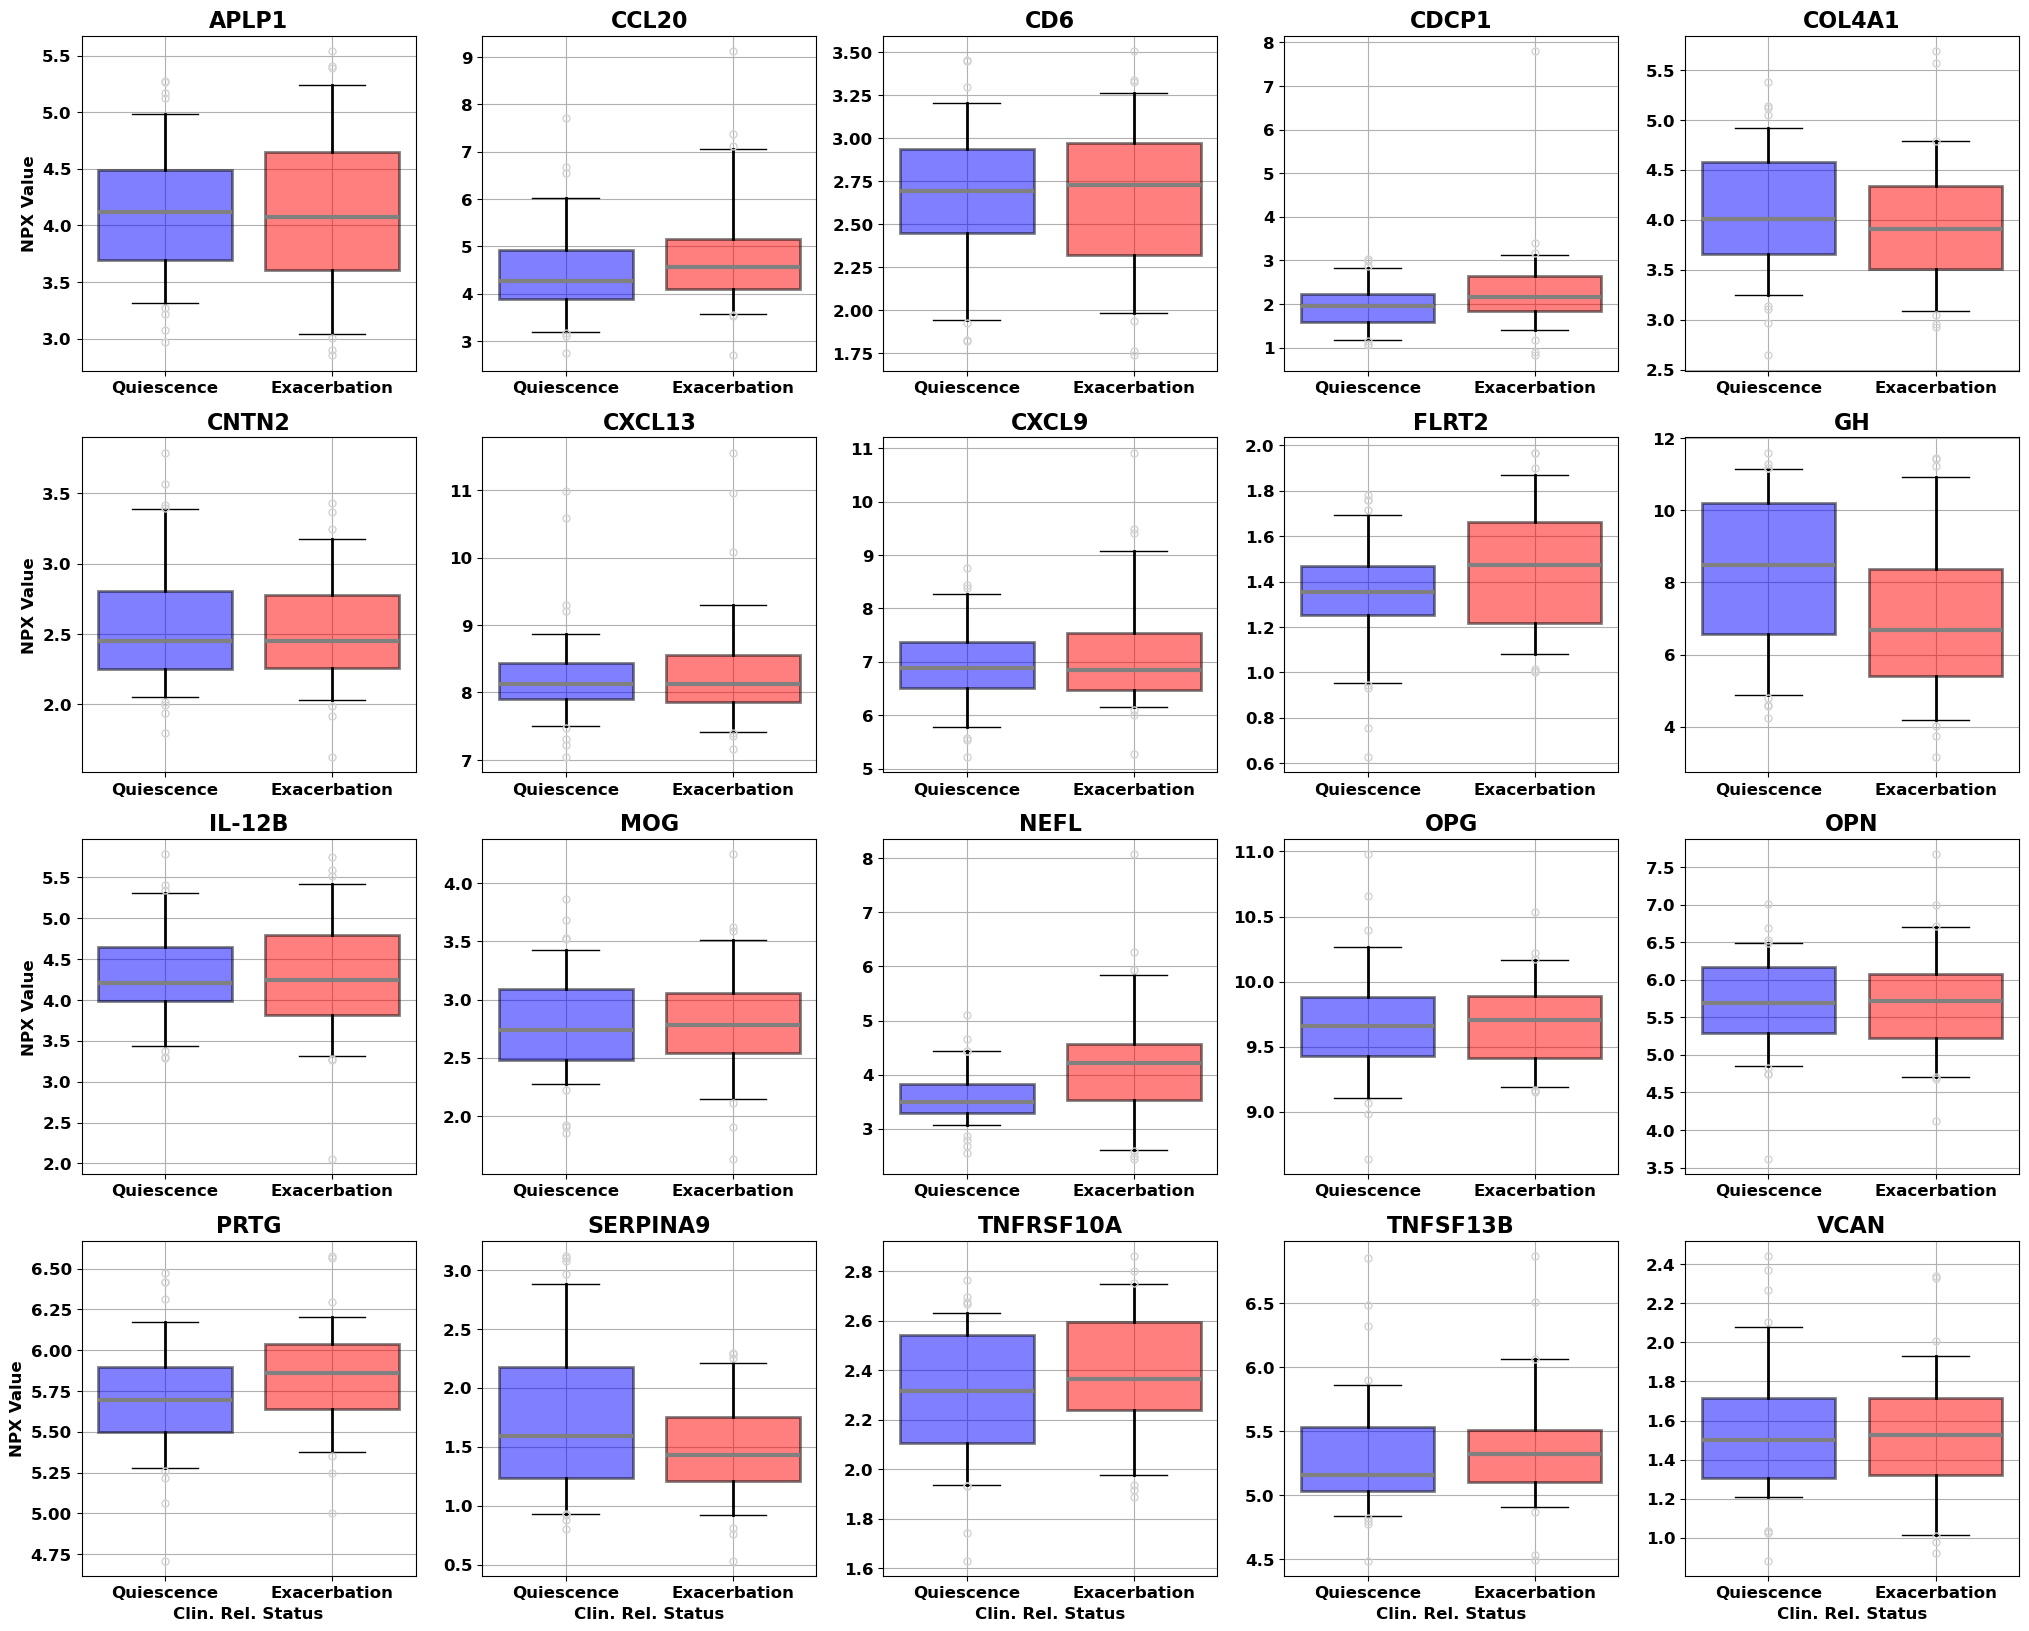

In [13]:
# Box and whisker configurations.
box_colors = [ "blue", "red" ]
# Create the figure.
fig, sub_plot = plt.subplots( 4, 5, figsize = ( 25., 20. ), facecolor = "white", edgecolor = "white" )
# Iterate over the subplots and protein features.
box_plots = [ sp.boxplot( [ combined_tables[ "acp" ][ ( combined_tables[ "acp" ][ "label" ] == 0. ) & combined_tables[ "acp" ][ bmkr ].notna() ][ bmkr ].values, \
                            combined_tables[ "acp" ][ ( combined_tables[ "acp" ][ "label" ] == 1. ) & combined_tables[ "acp" ][ bmkr ].notna() ][ bmkr ].values ], \
                          positions = np.arange( 2 ), sym = "o", patch_artist = True, widths = 0.8, whis = [ 5., 95. ], notch = False, \
                          boxprops = box_cfg, medianprops = box_median_cfg, whiskerprops = whsk_cfg, flierprops = flier_cfg ) \
              for sp, bmkr in zip( sub_plot.ravel(), protein_columns ) ]
# Formatting.
for sp, bmkr, box_plot in zip( sub_plot.ravel(), protein_columns, box_plots ):
    sp.set_title( bmkr.upper(), fontdict = title_font )
    sp.set_xticklabels( [ "Quiescence", "Exacerbation" ] )
    if sp in sub_plot[ 3, : ]:
        sp.set_xlabel( "Clin. Rel. Status", fontdict = fig_font )
    if sp in sub_plot[ :, 0 ]:
        sp.set_ylabel( "NPX Value", fontdict = fig_font )
    for patch, color in zip( box_plot[ "boxes" ], box_colors ):
        patch.set_facecolor( color )
    sp.grid( True )
plt.savefig( "./latex/figures/univar_boxplots_clin_rel_stat.pdf", dpi = 300., bbox_inches = "tight" )

Now, do a t test to look at univariate sepration

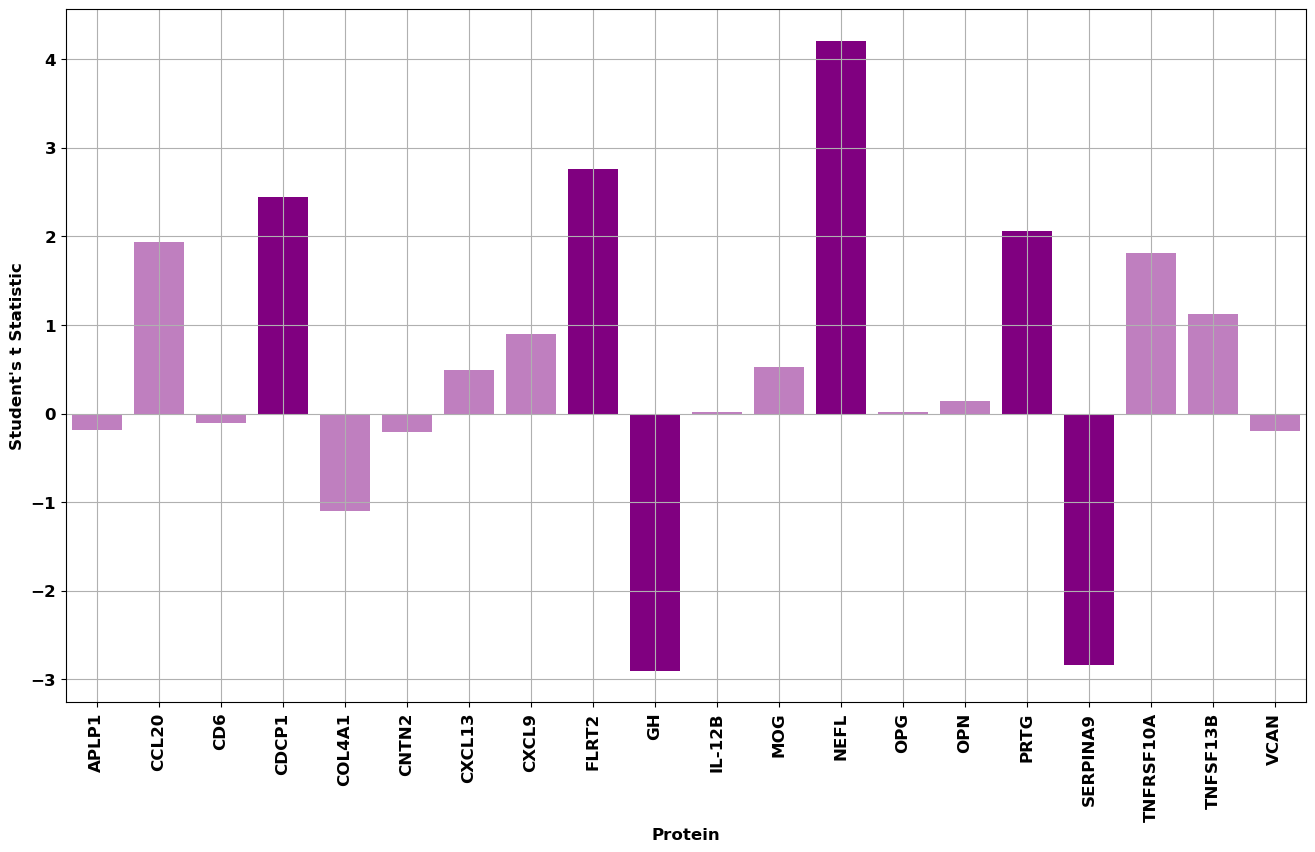

In [14]:
# Do the t test for each protein
clin_rel_t_tests = { prot: ttest_ind( combined_tables[ "acp" ][ combined_tables[ "acp" ][ "label" ].notna() & combined_tables[ "acp" ][ prot ].notna() & ( combined_tables[ "acp" ][ "label" ] >= 1. ) ][ prot ].values, \
                                      combined_tables[ "acp" ][ combined_tables[ "acp" ][ "label" ].notna() & combined_tables[ "acp" ][ prot ].notna() & ( combined_tables[ "acp" ][ "label" ] == 0. ) ][ prot ].values ) \
                     for prot in protein_columns }
# Create the figure.
fig, sub_plot = plt.subplots( 1, 1, figsize = ( 16., 9. ), facecolor = "white", edgecolor = "white" )
# Draw the bar chart.
sep_bars = sub_plot.bar( np.arange( len( protein_columns ) ), [ clin_rel_t_tests[ prot ].statistic for prot in protein_columns ], \
                         width = bar_width, align = "center", color = "purple" )
# Turn down the alpha on bars corresponding to tests that were not significant.
for sep_bar, prot in zip( sep_bars, protein_columns ):
    if clin_rel_t_tests[ prot ].pvalue > signif_thr:
        sep_bar.set_alpha( low_alpha )
# Formatting.
sub_plot.set_xlabel( "Protein", fontdict = fig_font )
sub_plot.set_xlim( [-0.5, len( protein_columns ) - 0.5 ] )
sub_plot.set_xticks( np.arange( len( protein_columns ) ) )
sub_plot.set_xticklabels( [ prot.upper() for prot in protein_columns ], rotation = 90., fontdict = fig_font )
sub_plot.set_ylabel( "Student's t Statistic", fontdict = fig_font )
sub_plot.grid( True )
plt.savefig( "./latex/figures/univar_sep_clin_rel_stat.pdf", dpi = 300., bbox_inches = "tight" )

In [15]:
pd.DataFrame( { "Clas. p-Val.": [ "{:1.3e}".format( clin_rel_t_tests[ prot ].pvalue ) for prot in protein_columns ] }, \
              index = [ prot.upper() for prot in protein_columns ] )

,Clas. p-Val.
APLP1,8.523e-01
CCL20,5.528e-02
CD6,9.189e-01
CDCP1,1.607e-02
COL4A1,2.732e-01
CNTN2,8.314e-01
CXCL13,6.220e-01
CXCL9,3.717e-01
FLRT2,6.618e-03
GH,4.377e-03


In [16]:
pd.DataFrame( { "Clas. p-Val.": [ "{:1.3e}".format( clin_rel_t_tests[ prot ].pvalue ) if clin_rel_t_tests[ prot ].pvalue < signif_thr else "" for prot in protein_columns ] }, \
              index = [ prot.upper() for prot in protein_columns ] )

,Clas. p-Val.
APLP1,
CCL20,
CD6,
CDCP1,1.607e-02
COL4A1,
CNTN2,
CXCL13,
CXCL9,
FLRT2,6.618e-03
GH,4.377e-03


In [17]:
pd.DataFrame( { "Classification": [ "{:} ({:1.3e})".format( protein_columns[ ind ].upper(), clin_rel_t_tests[ protein_columns[ ind ] ].pvalue ) \
                                    for ind in np.array( [ clin_rel_t_tests[ prot ].pvalue for prot in protein_columns ] ).argsort() ] }, \
              index = np.arange( 1, len( protein_columns ) + 1 ) )

,Classification
1,NEFL (5.025e-05)
2,GH (4.377e-03)
3,SERPINA9 (5.283e-03)
4,FLRT2 (6.618e-03)
5,CDCP1 (1.607e-02)
6,PRTG (4.180e-02)
7,CCL20 (5.528e-02)
8,TNFRSF10A (7.203e-02)
9,TNFSF13B (2.622e-01)
10,COL4A1 (2.732e-01)


## Annualized Relapse Rate
We're going to continue to just handle this as a classification probelem where low ARR is less than 0.2 relapses per year and high ARR is greater than 1.0. Fatima already tried doing a regression of ARR, and the [results](https://octavebio.atlassian.net/wiki/spaces/bloodbiomarkerDS/pages/292356211/ARR+Multivariate+Greedy+Forward+Selection+with+Demographic+Adjustment) were not encouraging.

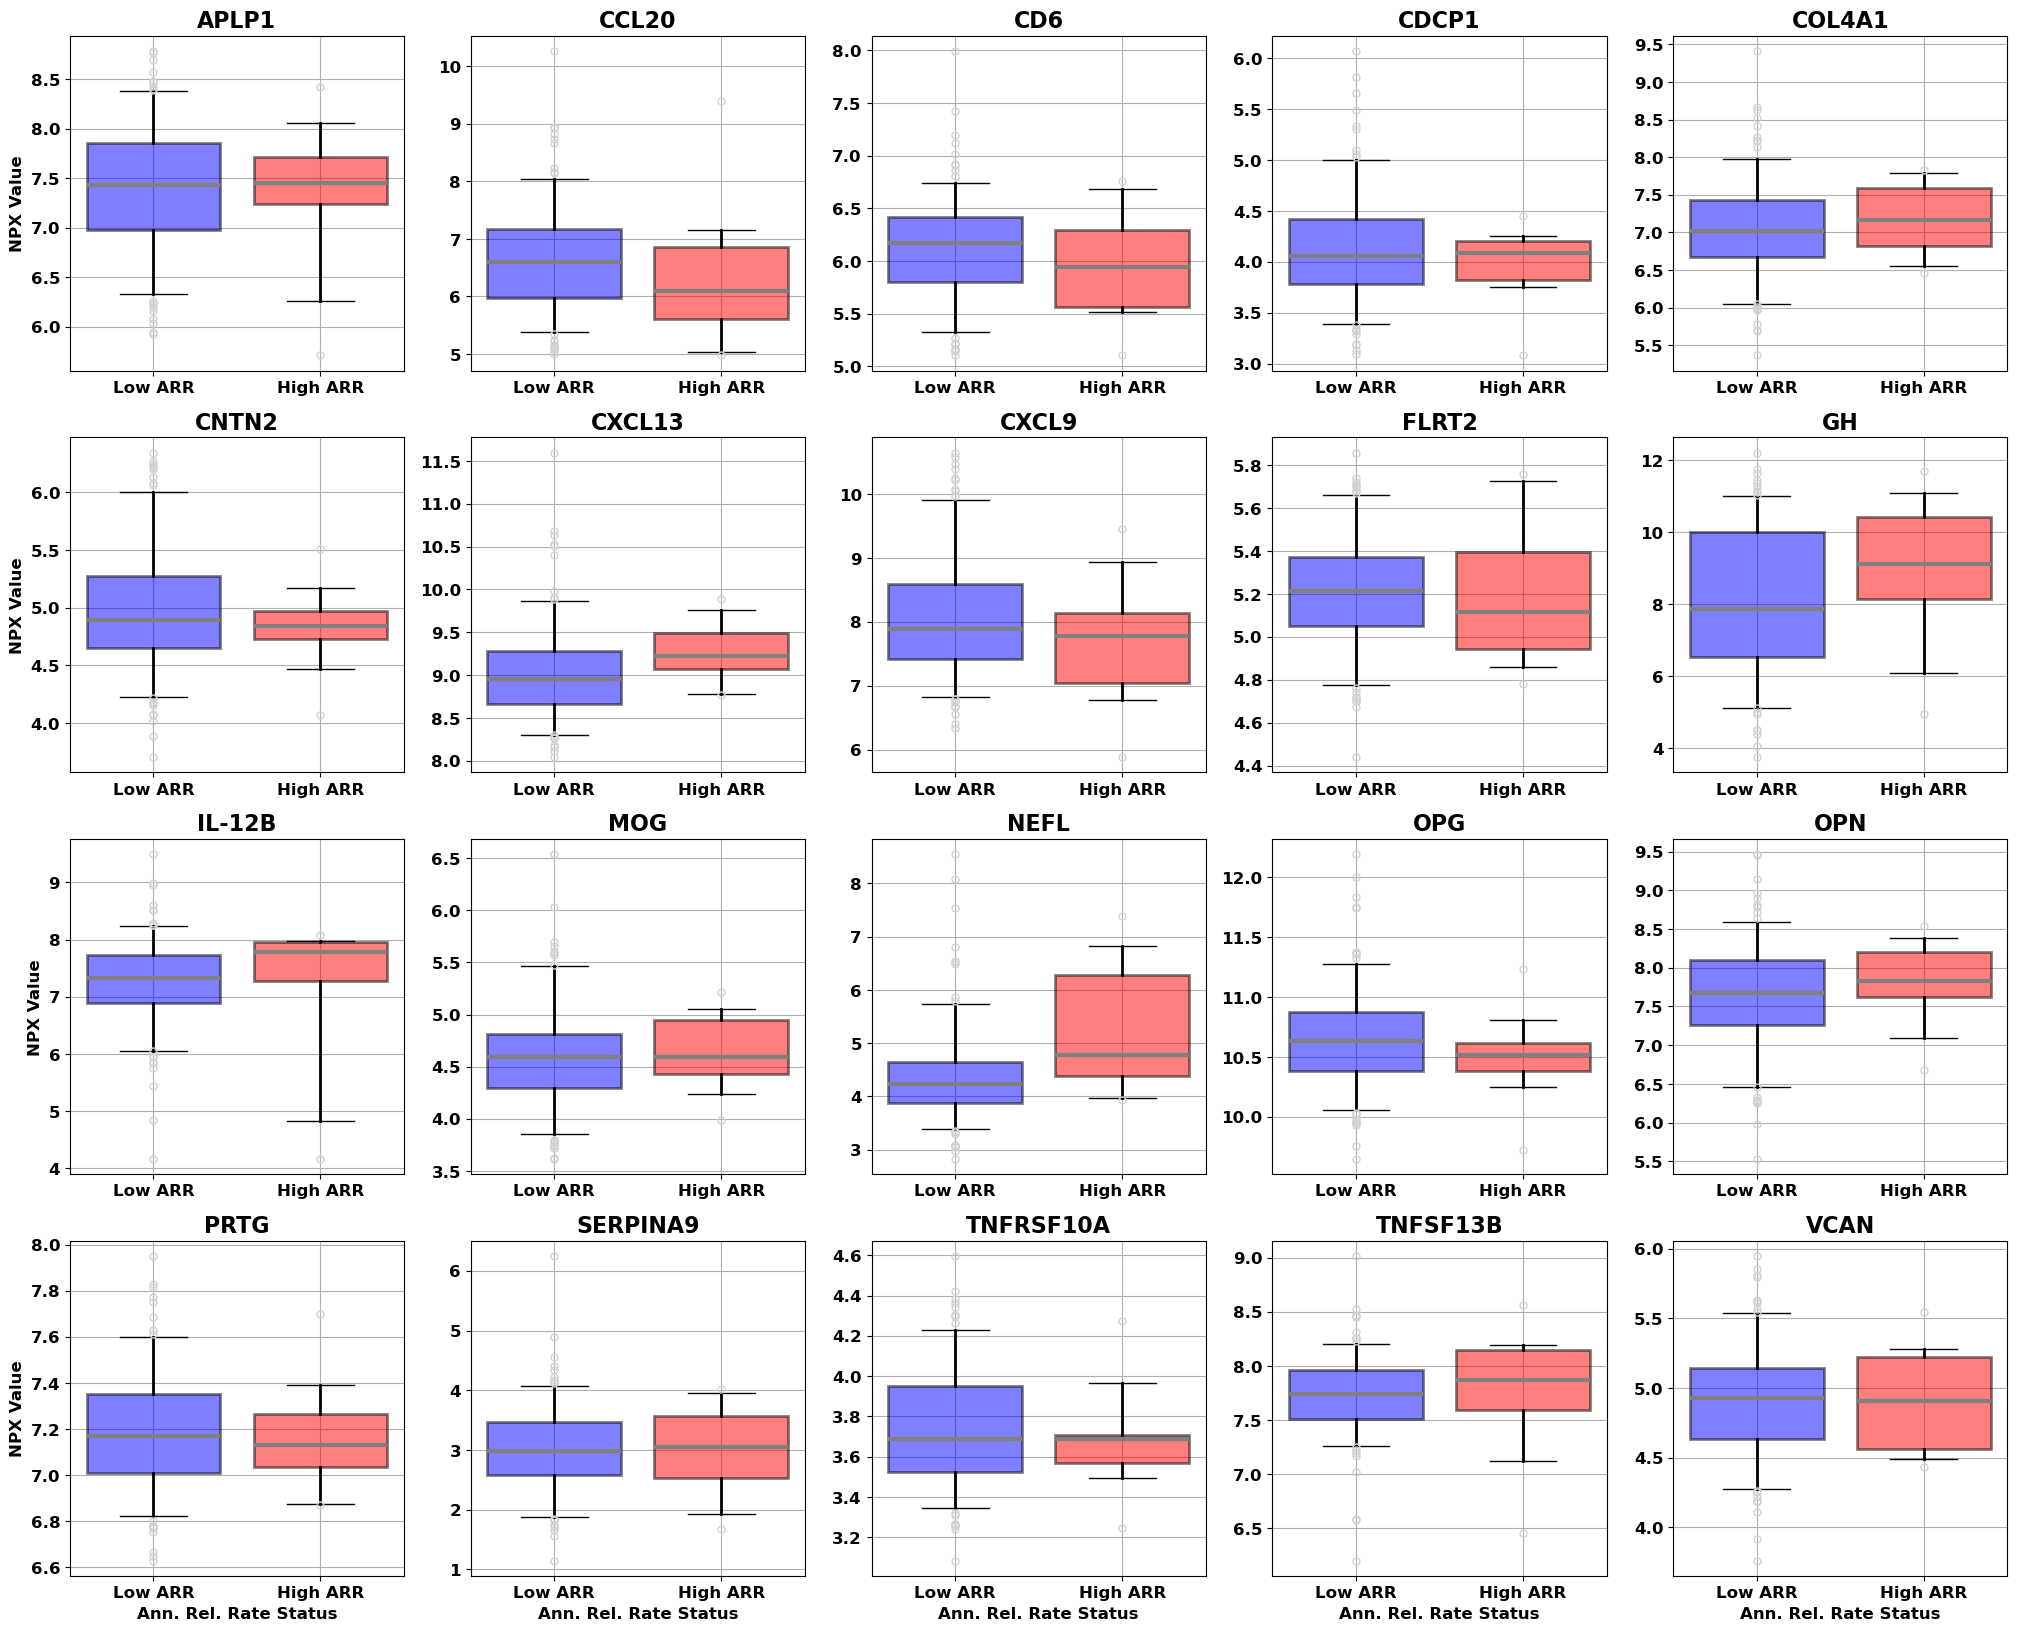

In [18]:
# Create the figure.
fig, sub_plot = plt.subplots( 4, 5, figsize = ( 25., 20. ), facecolor = "white", edgecolor = "white" )
# Iterate over the subplots and protein features.
box_plots = [ sp.boxplot( [ combined_tables[ "f4" ][ ( combined_tables[ "f4" ][ "arr" ] < 0.2 ) & combined_tables[ "f4" ][ bmkr ].notna() ][ bmkr ].values, \
                            combined_tables[ "f4" ][ ( combined_tables[ "f4" ][ "arr" ] >= 1. ) & combined_tables[ "f4" ][ bmkr ].notna() ][ bmkr ].values ], \
                          positions = np.arange( 2 ), sym = "o", patch_artist = True, widths = 0.8, whis = [ 5., 95. ], notch = False, \
                          boxprops = box_cfg, medianprops = box_median_cfg, whiskerprops = whsk_cfg, flierprops = flier_cfg ) \
              for sp, bmkr in zip( sub_plot.ravel(), protein_columns ) ]
# Formatting.
for sp, bmkr, box_plot in zip( sub_plot.ravel(), protein_columns, box_plots ):
    sp.set_title( bmkr.upper(), fontdict = title_font )
    sp.set_xticklabels( [ "Low ARR", "High ARR" ] )
    if sp in sub_plot[ 3, : ]:
        sp.set_xlabel( "Ann. Rel. Rate Status", fontdict = fig_font )
    if sp in sub_plot[ :, 0 ]:
        sp.set_ylabel( "NPX Value", fontdict = fig_font )
    for patch, color in zip( box_plot[ "boxes" ], box_colors ):
        patch.set_facecolor( color )
    sp.grid( True )
plt.savefig( "./latex/figures/univar_boxplots_arr.pdf", dpi = 300., bbox_inches = "tight" )

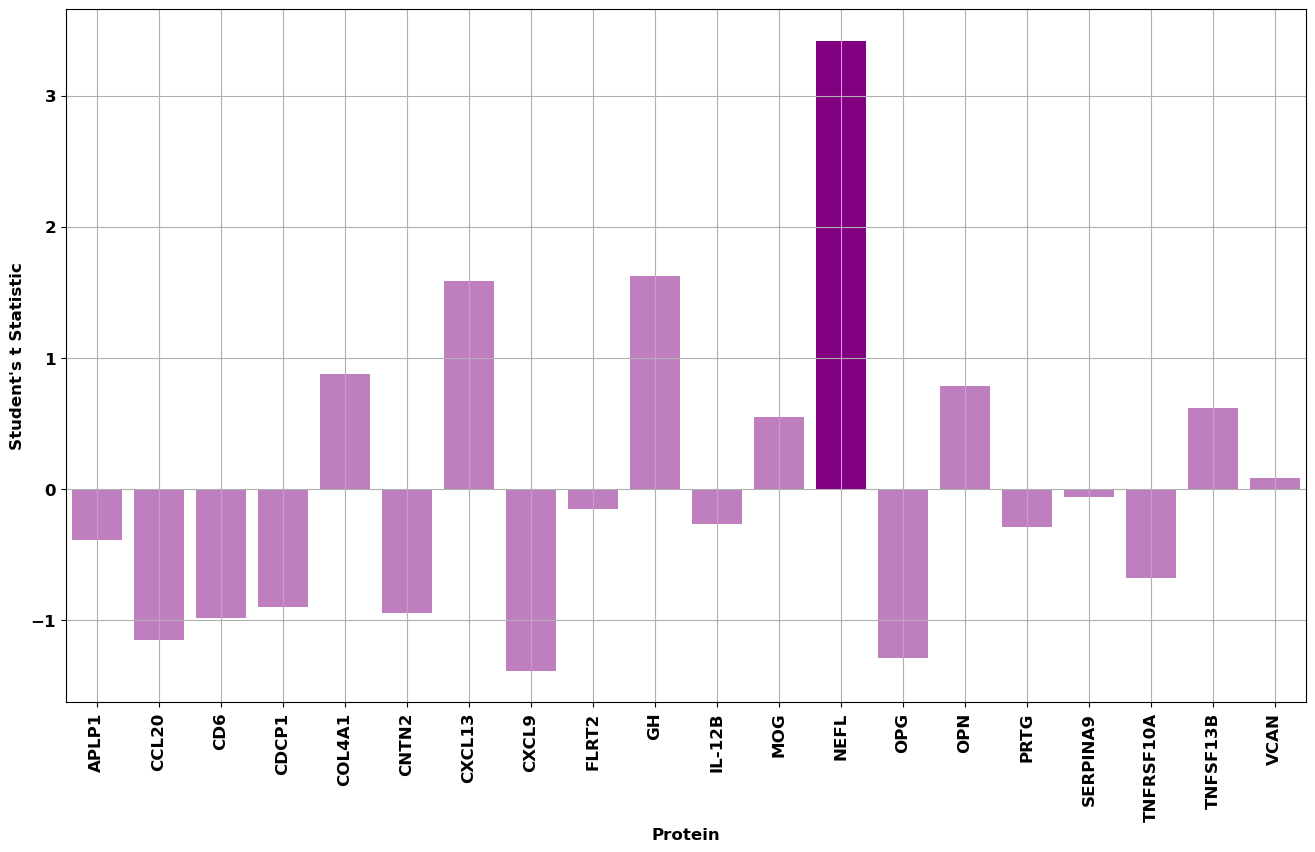

In [19]:
# Do the t test for each protein
arr_t_tests = { prot: ttest_ind( combined_tables[ "f4" ][ combined_tables[ "f4" ][ "arr" ].notna() & combined_tables[ "f4" ][ prot ].notna() & ( combined_tables[ "f4" ][ "arr" ] >= 1. ) ][ prot ].values, \
                                 combined_tables[ "f4" ][ combined_tables[ "f4" ][ "arr" ].notna() & combined_tables[ "f4" ][ prot ].notna() & ( combined_tables[ "f4" ][ "arr" ] < 0.2 ) ][ prot ].values ) \
                for prot in protein_columns }
# Create the figure.
fig, sub_plot = plt.subplots( 1, 1, figsize = ( 16., 9. ), facecolor = "white", edgecolor = "white" )
# Draw the bar chart.
sep_bars = sub_plot.bar( np.arange( len( protein_columns ) ), [ arr_t_tests[ prot ].statistic for prot in protein_columns ], \
                         width = bar_width, align = "center", color = "purple" )
# Turn down the alpha on bars corresponding to tests that were not significant.
for sep_bar, prot in zip( sep_bars, protein_columns ):
    if arr_t_tests[ prot ].pvalue > signif_thr:
        sep_bar.set_alpha( low_alpha )
# Formatting.
sub_plot.set_xlabel( "Protein", fontdict = fig_font )
sub_plot.set_xlim( [-0.5, len( protein_columns ) - 0.5 ] )
sub_plot.set_xticks( np.arange( len( protein_columns ) ) )
sub_plot.set_xticklabels( [ prot.upper() for prot in protein_columns ], rotation = 90., fontdict = fig_font )
sub_plot.set_ylabel( "Student's t Statistic", fontdict = fig_font )
sub_plot.grid( True )
plt.savefig( "./latex/figures/univar_sep_arr.pdf", dpi = 300., bbox_inches = "tight" )

OK, with only one significant protein let's just look at the NEFL p-value.

In [20]:
print( arr_t_tests[ "nefl" ] )
print( "{:1.2e}".format( arr_t_tests[ "nefl" ].pvalue ) )

TtestResult(statistic=3.4168034420630087, pvalue=0.0007851123384759073, df=178.0)
7.85e-04


## Summary plot of all univariate results.
We need to combine all these into one figure so that we can save some space in our (hopefully) _Nature_ paper.

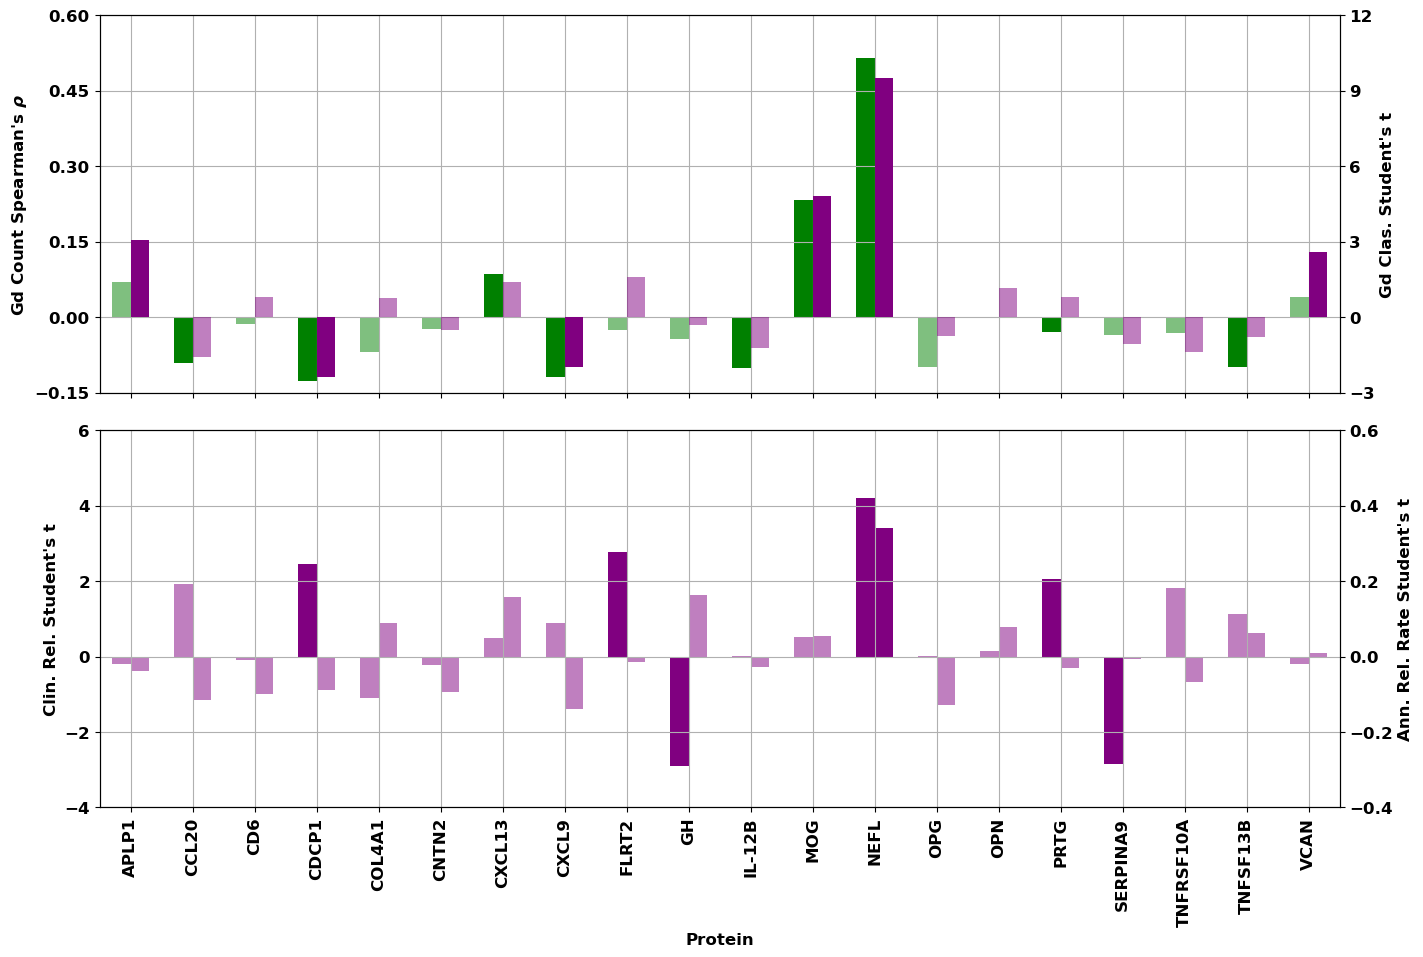

In [21]:
# Now plot both of these results together. Define some plotting constants.
bar_width, n_bars = 0.6, 2
bar_offsets = np.arange( 0., bar_width, bar_width / n_bars ) + ( bar_width / n_bars / 2. ) - ( bar_width / 2. )
# Create the figure.
fig, sub_plot = plt.subplots( 2, 1, figsize = ( 16., 9. ), facecolor = "white", edgecolor = "white" )
rhs_plot = [ sp.twinx() for sp in sub_plot ]
# Plot the test statistics as bar charts for the four tests we performed.
gd_cor_bars = sub_plot[ 0 ].bar( np.arange( len( protein_columns ) ) + bar_offsets[ 0 ], \
                                 [ gd_corr_spr[ prot ][ 0 ] for prot in protein_columns ], \
                                 width = bar_width / n_bars, align = "center", color = "green" )
gd_sep_bars = rhs_plot[ 0 ].bar( np.arange( len( protein_columns ) ) + bar_offsets[ 1 ], \
                                 [ gd_t_tests[ prot ].statistic for prot in protein_columns ], \
                                 width = bar_width / n_bars, align = "center", color = "purple" )
cr_sep_bars = sub_plot[ 1 ].bar( np.arange( len( protein_columns ) ) + bar_offsets[ 0 ], \
                                 [ clin_rel_t_tests[ prot ].statistic for prot in protein_columns ], \
                                 width = bar_width / n_bars, align = "center", color = "purple" )
ar_sep_bars = sub_plot[ 1 ].bar( np.arange( len( protein_columns ) ) + bar_offsets[ 1 ], \
                                 [ arr_t_tests[ prot ].statistic for prot in protein_columns ], \
                                 width = bar_width / n_bars, align = "center", color = "purple" )
# Turn down the alpha on bars corresponding to tests that were not significant.
signif_thr, low_alpha = 0.05, 0.5
for bars, results in zip( [ gd_cor_bars,     gd_sep_bars, cr_sep_bars,      ar_sep_bars ], \
                          [ gd_correlations, gd_t_tests,  clin_rel_t_tests, arr_t_tests ] ):
    for bar, prot in zip( bars, protein_columns ):
        try:
            if results[ prot ][ 1 ] > signif_thr:
                bar.set_alpha( low_alpha )
        except:
            if results[ prot ].pvalue > signif_thr:
                bar.set_alpha( low_alpha )
# Formatting.
plt.subplots_adjust( wspace = 0.1, hspace = 0.1, top = 0.99 )
rho_lim = np.array( [ -0.15, 0.6 ] )
t_lim   = np.array( [ -3., 12. ] )
for sp, rh in zip( sub_plot, rhs_plot ):
    sp.set_xlim( [-0.5, len( protein_columns ) - 0.5 ] )
    sp.set_xticks( np.arange( len( protein_columns ) ) )
    if sp == sub_plot[ -1 ]:
        sp.set_xticklabels( [ prot.upper() for prot in protein_columns ], rotation = 90., fontdict = fig_font )
        sp.set_xlabel( "Protein", fontdict = fig_font )
        sp.set_ylim( [ -4., 6. ] )
        rh.set_ylim( [ -0.4, 0.6 ] )
        sp.set_ylabel( "Clin. Rel. Student's t", fontdict = fig_font )
        rh.set_ylabel( "Ann. Rel. Rate Student's t", fontdict = fig_font )
    else:
        sp.set_xticklabels( "" )
        sp.set_ylim( rho_lim )
        rh.set_ylim( t_lim )
        sp.set_ylabel( "Gd Count Spearman's $\\rho$", fontdict = fig_font )
        rh.set_ylabel( "Gd Clas. Student's t", fontdict = fig_font )
    sp.set_yticks( np.linspace( *sp.get_ylim(), 6 ) )
    rh.set_yticks( np.linspace( *rh.get_ylim(), 6 ) )
    sp.grid( True )
plt.savefig( "./latex/figures/univar_corr_sep_all.png", dpi = 300, bbox_inches = "tight" )
plt.savefig( "./latex/figures/univar_corr_sep_all.pdf", dpi = 300, bbox_inches = "tight" )

In [22]:
all_univar_endpoint_stats = pd.DataFrame( { "Gd Corr. Sp. rho": [ gd_corr_spr[ prot ][ 0 ] for prot in protein_columns ],
                                          "Gd Corr. Sp. p-val": [ gd_corr_spr[ prot ][ 1 ] for prot in protein_columns ],
                                         "Gd Clas. St. t stat": [ gd_t_tests[ prot ].statistic for prot in protein_columns ],
                                        "Gd Clas. St. t p-val": [ gd_t_tests[ prot ].pvalue for prot in protein_columns ],
                                       "Clin. Rel. St. t stat": [ clin_rel_t_tests[ prot ].statistic for prot in protein_columns ],
                                      "Clin. Rel. St. t p-val": [ clin_rel_t_tests[ prot ].pvalue for prot in protein_columns ],
                                   "Ann. Rel. Rate St. t stat": [ arr_t_tests[ prot ].statistic for prot in protein_columns ],
                                  "Ann. Rel. Rate St. t p-val": [ arr_t_tests[ prot ].pvalue for prot in protein_columns ] }, 
                                          index = [ prot.upper() for prot in protein_columns ] )
all_univar_endpoint_stats

,Gd Corr. Sp. rho,Gd Corr. Sp. p-val,Gd Clas. St. t stat,Gd Clas. St. t p-val,Clin. Rel. St. t stat,Clin. Rel. St. t p-val,Ann. Rel. Rate St. t stat,Ann. Rel. Rate St. t p-val
APLP1,0.070812,1.141438e-01,3.064085,2.301943e-03,-0.186630,0.852261,-0.389105,0.697643
CCL20,-0.091958,4.188191e-02,-1.593165,1.117706e-01,1.937272,0.055276,-1.146712,0.253006
CD6,-0.012652,7.799710e-01,0.805730,4.207910e-01,-0.102115,0.918851,-0.982123,0.327343
CDCP1,-0.126593,5.009744e-03,-2.372595,1.805029e-02,2.445047,0.016070,-0.895430,0.371740
COL4A1,-0.069895,1.219307e-01,0.748658,4.544231e-01,-1.100751,0.273227,0.878142,0.381024
CNTN2,-0.024233,5.925567e-01,-0.522006,6.019031e-01,-0.213395,0.831381,-0.944065,0.346381
CXCL13,0.086776,5.617122e-02,1.383952,1.670122e-01,0.494280,0.622012,1.585931,0.114510
CXCL9,-0.119033,8.350239e-03,-1.989835,4.716674e-02,0.896940,0.371710,-1.385936,0.167462
FLRT2,-0.026141,5.645607e-01,1.590617,1.123461e-01,2.764043,0.006618,-0.150484,0.880550
GH,-0.043970,3.323959e-01,-0.326812,7.439510e-01,-2.906154,0.004377,1.628638,0.105119


In [23]:
all_univar_endpoint_stats.to_excel( "./latex/figures/univar_corr_sep_all.xlsx" )